In [1]:
# S2 signal script
import sys
import os

current_dir = '/scratch/marian/CIGAR_ANALYSIS/CIGAR/notebooks'

# Build the absolute path to ../functions
functions_path = os.path.abspath(os.path.join(current_dir, '../functions'))

# Add it to sys.path
sys.path.append(functions_path)

import cigar as cig
import matplotlib.pyplot  as plt
import numpy              as np
import pandas             as pd
import tables             as tb
import scipy
from scipy.optimize import curve_fit


##  Data reading

In [18]:
directory   = '/data/marian/cigar/ProcessedWaveforms/'

run_noKr    = 'no_source_7.5bar_ArXe_2deg/'
file_noKr   = '20250609_ArXe_7.5bar_no_source_2deg_Autotrg_output_10.csv'

run_Kr      = 'Kr_7.5bar_ArXe_2deg/'
file_Kr     = '20250609_ArXe_7.5bar_Kr_2deg_Autotrg_output_10.csv'


In [44]:
hist_directory  = '/data/marian/cigar/hists/'

source = 'None'

hist_Kr         = '20250610_ArXe_6.5bar_Kr_4deg_Autotrg_hist.pkl'
hist_noKr       = '20250610_ArXe_6.5bar_no_source_4deg_Autotrg_hist.pkl'

In [45]:
import pickle

In [46]:
pes     = False
amp     = False
temp    = '2deg'

# Open and load the pickle file
if (source == 'None') or (source == 'Both'):
    with open(hist_directory + hist_noKr, "rb") as f:
        data_noKr = pickle.load(f)
elif (source == 'Kr') or (source == 'Both'):
    with open(hist_directory + hist_Kr, "rb") as f:
        data_Kr = pickle.load(f)


In [47]:
cig.ChargeToPes(np.array([0.35e-6]), 4, temp = '2deg', amplified = False)

array([5.96526138])

In [48]:
pes = False

/tmp/ipykernel_1087406/1453030266.py:159: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


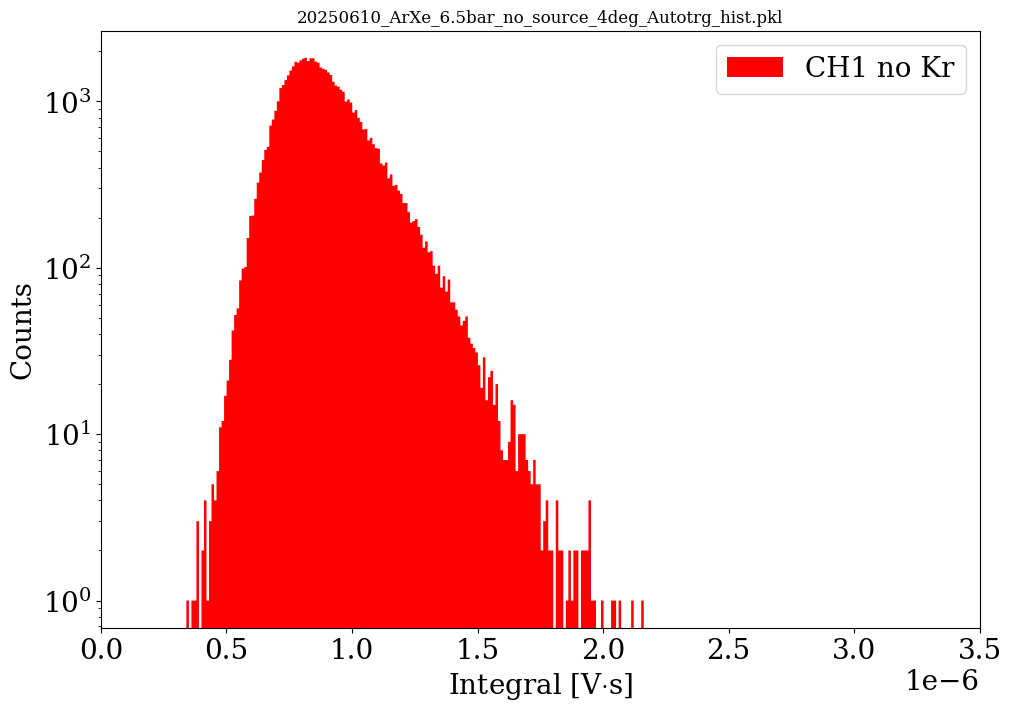

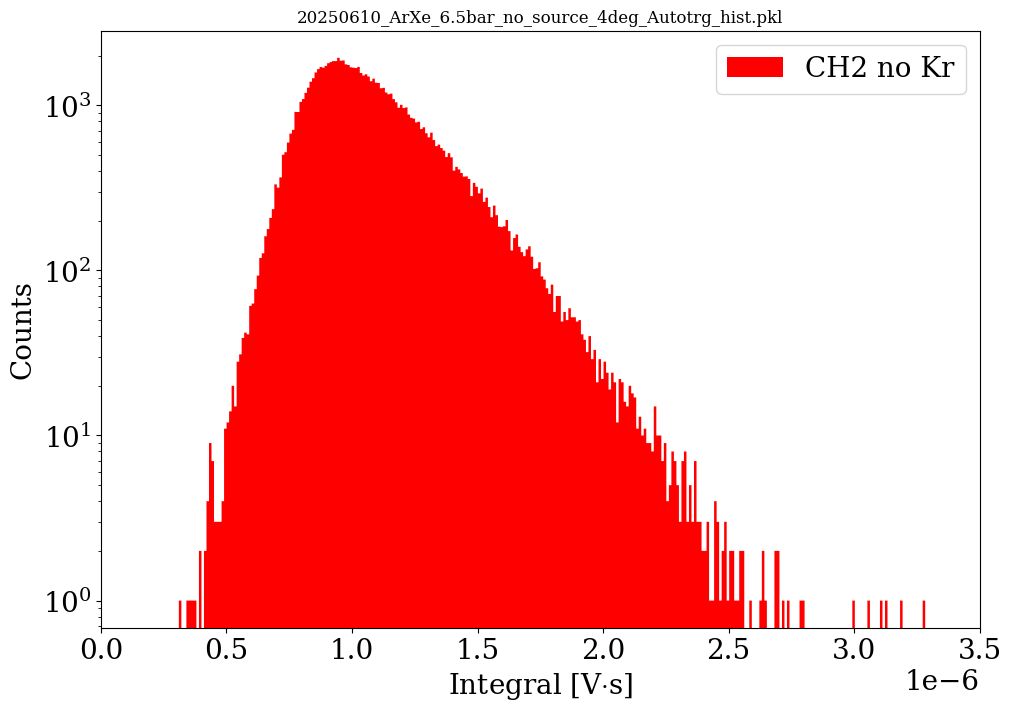

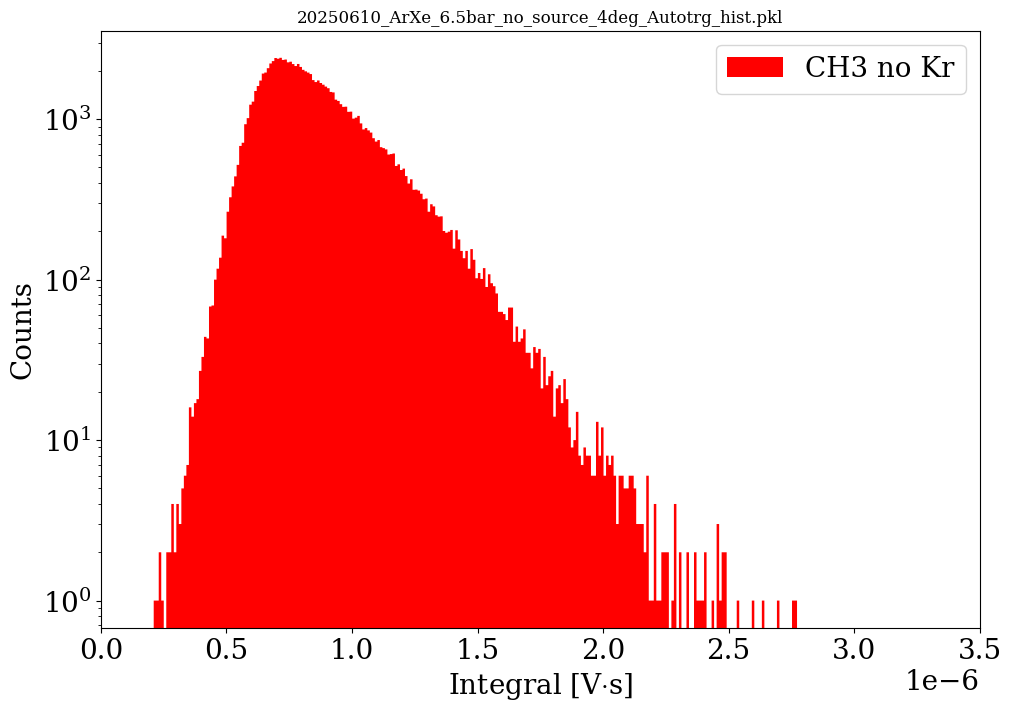

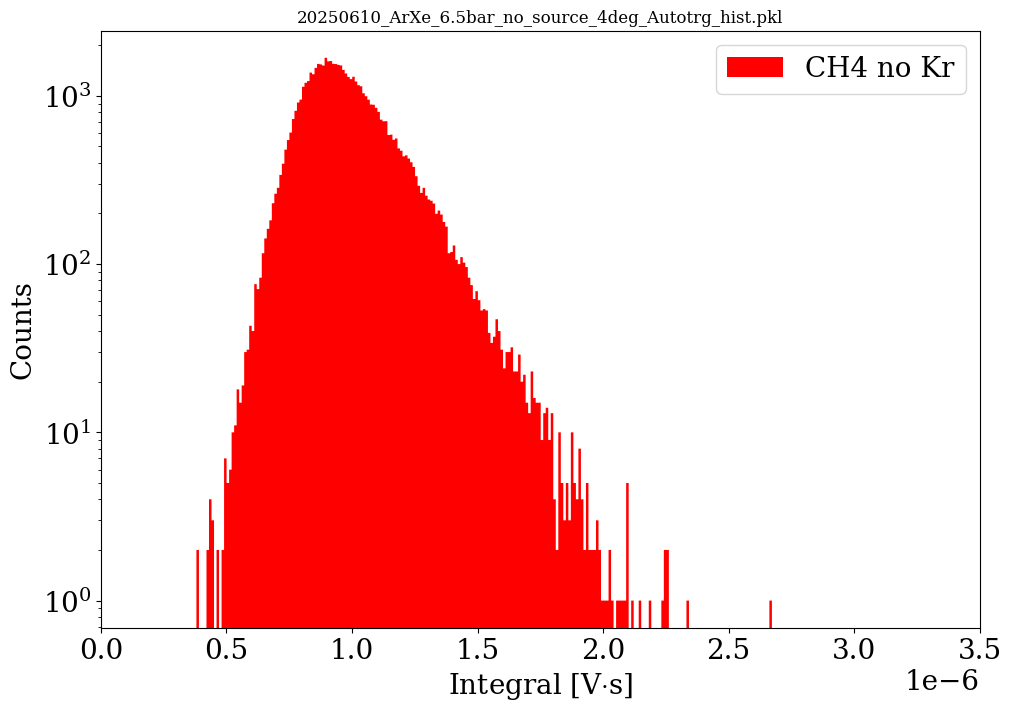

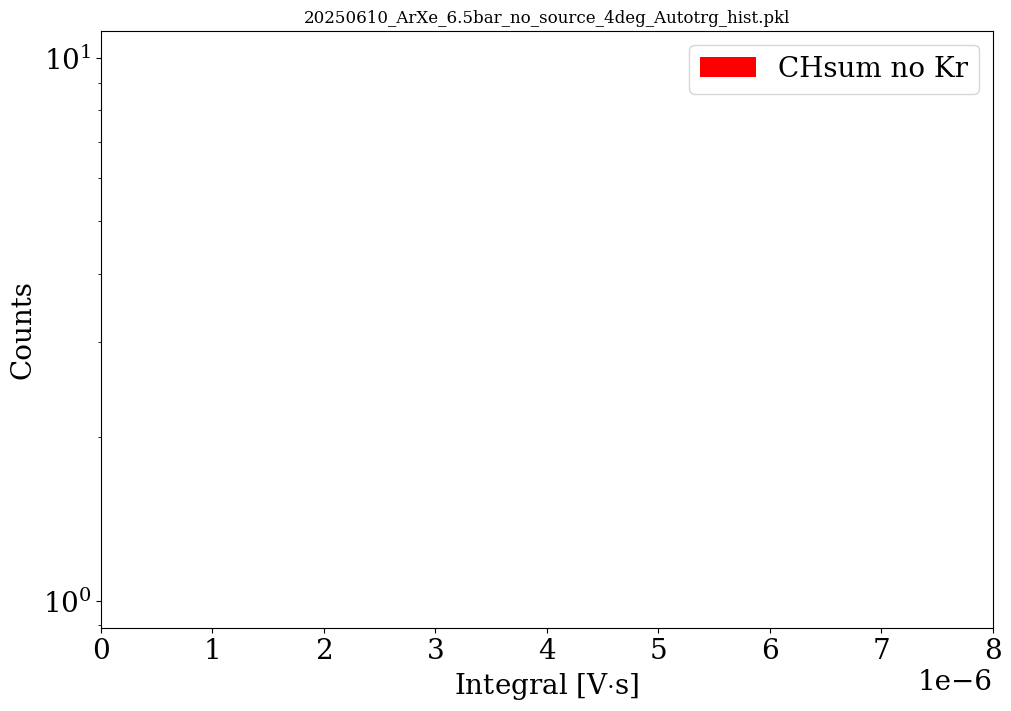

In [49]:
bins = np.linspace(0, 10e-6, 1000) # V*s
bin_centers = bins[:-1] + np.diff(bins)/2 # V*s


# Define a common PES binning
pes_bins        = np.linspace(0, 500, 1000)  # Define based on expected range of photoelectrons

if (source == 'None') or (source == 'Both'):
    sum_counts_noKr = data_noKr[f'CHSum'] # counts

elif (source == 'Kr') or (source == 'Both'):
    sum_counts_Kr   = data_Kr[f'CHSum'] # counts


for ch in [1, 2, 3, 4]:
    
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10, 7), constrained_layout=True)

    font_size = 20

    if (source == 'None') or (source == 'Both'):
        counts_noKr    = data_noKr[f'CH{ch}'] # counts
    elif (source == 'Kr') or (source == 'Both'):
        counts_Kr      = data_Kr[f'CH{ch}'] # counts

    if pes:
        # Convert V*s bin centers to Pes
        pes_centers = cig.ChargeToPes(bin_centers, channel=ch, temp=temp, amplified=amp)

        binin = pes_bins
        binin_center = pes_centers

        # Sample each PES histogram by repeating bin centers based on counts (slow but clear)
        # values_Kr = np.repeat(pes_centers, counts_Kr.astype(int))
        # values_noKr = np.repeat(pes_centers, counts_noKr.astype(int))

    else:
        binin = bins
        binin_center = bin_centers

        # Sample each PES histogram by repeating bin centers based on counts (slow but clear)
        # values_Kr = np.repeat(bin_centers, counts_Kr.astype(int))
        # values_noKr = np.repeat(bin_centers, counts_noKr.astype(int))

    
    if (source == 'None') or (source == 'Both'):
        events_noKr, bins_noKr, image = ax.hist(binin_center 
                                                ,bins = binin 
                                                ,weights = counts_noKr
                                                ,density = False
                                                ,histtype   ='stepfilled'
                                                ,color      = 'r'
                                                ,ls         = '-'
                                                ,lw         = 3
                                                ,alpha      = 1
                                                ,label = f'CH{ch} no Kr'
                                                )
    elif (source == 'Kr') or (source == 'Both'):
        events_Kr, bins_Kr, image = ax.hist(binin_center 
                                            ,bins = binin 
                                            ,weights = counts_Kr
                                            ,density = False
                                            ,histtype   ='step'
                                            ,color      = 'k'
                                            ,ls         = '-'
                                            ,lw         = 3
                                            ,alpha      = 1
                                            ,label = f'CH{ch} Kr'
                                            )
    

    if pes:
        ax.set_xlabel(r'Phes', fontsize = font_size);
    else:
        ax.set_xlabel(r'Integral [V$\cdot$s]', fontsize = font_size);
    ax.set_ylabel(r'Counts', fontsize = font_size);

    if source == 'Both':
        text = f"""
        Kr/noKr = {events_Kr.sum()/events_noKr.sum():.2f}
        """
        ax.text(0.6, .7, text,
        transform=ax.transAxes, fontsize=font_size, fontfamily='monospace', bbox=dict(facecolor='1.', edgecolor='none', pad=3.0, alpha = 0))


    ax.legend(loc = 'best')
    if pes:
        ax.set_xlim(0, 100)
    else:
        ax.set_xlim(0, 0.35e-5)

    if source == 'None':
        ax.set_title(f'{hist_noKr}', fontsize = 0.6*font_size);
    elif source == 'Kr':
        ax.set_title(f'{hist_Kr} ' , fontsize = 0.6*font_size);
    elif source == 'Both':
        ax.set_title(f'{hist_Kr} ' + r'$\bf{VS}$ ' + f'{hist_noKr}', fontsize = 0.6*font_size);

    ax.set_yscale('log')


# Sum histogram
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10, 7), constrained_layout=True)


if (source == 'None') or (source == 'Both'):
    events_noKr, bins_noKr, image = ax.hist(binin_center 
                                            ,bins = binin 
                                            ,weights = sum_counts_noKr
                                            ,density = False
                                            ,histtype   ='stepfilled'
                                            ,color      = 'r'
                                            ,ls         = '-'
                                            ,lw         = 3
                                            ,alpha      = 1
                                            ,label = f'CHsum no Kr'
                                            )
elif (source == 'Kr') or (source == 'Both'):
    events_Kr, bins_Kr, image = ax.hist(binin_center 
                                        ,bins = binin 
                                        ,weights = sum_counts_Kr
                                        ,density = False
                                        ,histtype   ='step'
                                        ,color      = 'k'
                                        ,ls         = '-'
                                        ,lw         = 3
                                        ,alpha      = 1
                                        ,label = f'CHsum Kr'
                                        )


if pes:
    ax.set_xlabel(r'Phes', fontsize = font_size);
else:
    ax.set_xlabel(r'Integral [V$\cdot$s]', fontsize = font_size);
ax.set_ylabel(r'Counts', fontsize = font_size);

if source == 'Both':
    text = f"""
    Kr/noKr = {events_Kr.sum()/events_noKr.sum():.2f}
    """
    ax.text(0.6, .7, text,
    transform=ax.transAxes, fontsize=font_size, fontfamily='monospace', bbox=dict(facecolor='1.', edgecolor='none', pad=3.0, alpha = 0))


ax.legend(loc = 'best')
if pes:
    ax.set_xlim(0, 150)
else:
    ax.set_xlim(0, 0.8e-5)

if source == 'None':
    ax.set_title(f'{hist_noKr}', fontsize = 0.6*font_size);
elif source == 'Kr':
    ax.set_title(f'{hist_Kr} ' , fontsize = 0.6*font_size);
elif source == 'Both':
    ax.set_title(f'{hist_Kr} ' + r'$\bf{VS}$ ' + f'{hist_noKr}', fontsize = 0.6*font_size);

ax.set_yscale('log')

